<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">The work plan : </h1></center>

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.05em;">
    
Part 1 :
Scraping data. 

Part 2 :
Clustering data using Scikit-learn.


Part 3:
Clustering data using PySpark.</h2>




# Scraping Data :

### •Using scrapy to extract job offers information from «https://www.offre-emploi.tn/»

In [ ]:
pip install Scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%writefile jobs_spider.py

import scrapy


class JobsSpider(scrapy.Spider):
    name = "jobs"
    start_urls = [
        'https://www.offre-emploi.tn',

    ]
    def parse(self, response):
      for js_result_row in response.css('article.js_result_row'):
        yield {
                'title': js_result_row.css('.jobTitle span::text').get(),
                'location': js_result_row.css('.location a:nth-child(even) span::text').get(),
                'poste': js_result_row.css('.location a:nth-child(odd) span::text').get(),
                'preview': js_result_row.css('.preview::text').get(),
                'date': js_result_row.css('.extras time::text').get(),
              }
      next_page = response.css('.pagingWrapper ul li:last-child a::attr(href)').get()
      if next_page is not None:
        yield response.follow(next_page, callback=self.parse)

Overwriting jobs_spider.py


In [ ]:
!scrapy runspider jobs_spider.py -o jobs.jsonl

2022-12-03 01:08:24 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: scrapybot)
2022-12-03 01:08:24 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.0, Twisted 22.10.0, Python 3.8.15 (default, Oct 12 2022, 19:14:39) - [GCC 7.5.0], pyOpenSSL 22.1.0 (OpenSSL 3.0.7 1 Nov 2022), cryptography 38.0.4, Platform Linux-5.10.133+-x86_64-with-glibc2.27
2022-12-03 01:08:24 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
/usr/local/lib/python3.8/dist-packages/scrapy/utils/request.py:231: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IM

# Clustering Data using Scikit-Learn:

## I. Reading the Data
## II. Cleaning the Data
## III. Creating TF-IDF
## IV. Clustering the Data using K-means

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
#Importing the data :
data = pd.read_json('/content/jobs.jsonl', lines=True)
data.head()

title   location  \
0       DDSLweb recrute Graphiste Freelance – France      Tunis   
1    Scarp Trading 24 recrute Assistante Commerciale  Ben Arous   
2      Fleur de Lis recrute des Vendeurs / Vendeuses      Tunis   
3                                               None       None   
4  Masdar Consulting recrute Ingénieur DevOps –  ...      Tunis   

                          poste  \
0                     Freelance   
1               Offres d'emploi   
2  Vendeur- Ouvrier - Chauffeur   
3                          None   
4          Conseil - Consulting   

                                             preview  \
0  \n        Dans le cadre du développement de no...   
1  \n        Scarp Trading 24 recrute Assistante ...   
2  \n        Fleur de Lis recrute Des Vendeurs / ...   
3                                               None   
4  \n        MASDAR Consulting, entreprise de con...   

                           date  
0  01 décembre 2022              
1  01 décembre 2022              
2  01 décembre 2022              
3                          None  
4  01 décembre 2022

In [ ]:
#select only the title and poste columns
col = ['title','poste']

In [ ]:
data = data[col]
data.head(8)

title  \
0       DDSLweb recrute Graphiste Freelance – France   
1    Scarp Trading 24 recrute Assistante Commerciale   
2      Fleur de Lis recrute des Vendeurs / Vendeuses   
3                                               None   
4  Masdar Consulting recrute Ingénieur DevOps –  ...   
5                Leadfox recrute Assistante – Canada   
6          Marhaba Occidental recrute Réceptionniste   
7                                               None   

                          poste  
0                     Freelance  
1               Offres d'emploi  
2  Vendeur- Ouvrier - Chauffeur  
3                          None  
4          Conseil - Consulting  
5          Conseil - Consulting  
6     Restauration - Hôtellerie  
7                          None

In [ ]:
# Drop rows with missing labels :
data.dropna(subset=["title","poste"], inplace=True)

In [ ]:
data.head()

title  \
0       DDSLweb recrute Graphiste Freelance – France   
1    Scarp Trading 24 recrute Assistante Commerciale   
2      Fleur de Lis recrute des Vendeurs / Vendeuses   
4  Masdar Consulting recrute Ingénieur DevOps –  ...   
5                Leadfox recrute Assistante – Canada   

                          poste  
0                     Freelance  
1               Offres d'emploi  
2  Vendeur- Ouvrier - Chauffeur  
4          Conseil - Consulting  
5          Conseil - Consulting

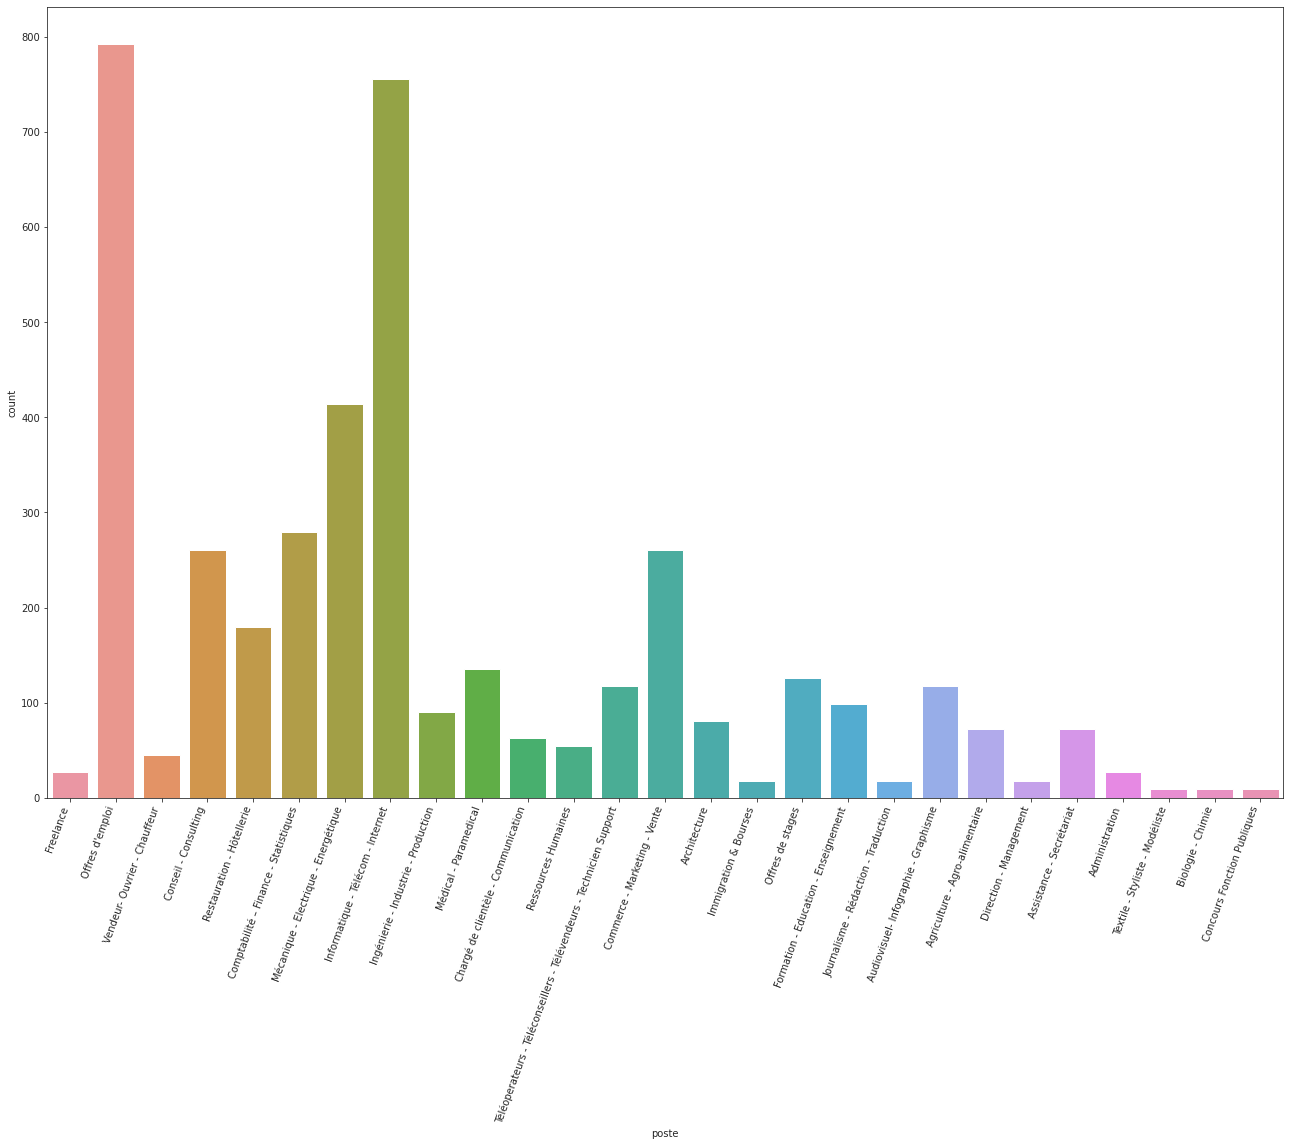

In [ ]:
#Plot the data :

# styledict, or one of {darkgrid, whitegrid, dark, white, ticks}
sns.set_style('ticks')
#fig size (width=18,height=16  in inches)
plt.figure(figsize=(18, 16))
#seaborn.countplot() method is used to Show the counts of observations in each categorical bin using bars.
ax = sns.countplot(x='poste', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
#The tight_layout() function used to automatically adjust subplot parameters to give specified padding.
plt.tight_layout(pad=1)
plt.show()

In [ ]:
#Clean the data :
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_é]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = str(text).lower()

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)

    # Remove the XXXX values
    text = text.replace('x', '')
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text)

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    #text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data["title"] = data["title"].apply(clean_text)

In [ ]:
data.head(8)

title  \
0         ddslweb recrute graphiste freelance france   
1       scarp trading recrute assistante commerciale   
2        fleur de lis recrute des vendeurs vendeuses   
4  masdar consulting recrute ingénieur devops par...   
5                   leadfo recrute assistante canada   
6          marhaba occidental recrute réceptionniste   
8  elite services sécurité recrute des agents de ...   
9                 cabinet gem recrute des comptables   

                                   poste  
0                              Freelance  
1                        Offres d'emploi  
2           Vendeur- Ouvrier - Chauffeur  
4                   Conseil - Consulting  
5                   Conseil - Consulting  
6              Restauration - Hôtellerie  
8                        Offres d'emploi  
9  Comptabilité – Finance - Statistiques

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [ ]:
# Run TF IDF Vectorizer on the text data

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df to ignore terms that appear in less than 5 documents
# max_df to ignore terms that appear in more than 55% of the documents
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
#Extracting keywords: Here I use the TfidfVectorizer since I'm hoping the IDF score will pull out unique words that I can use in clustering. There are lots of options to explore here to get different results, including CountVectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf= True,
    norm='l2',
    ngram_range=(1, 2),
    min_df = 5,
    max_df = 0.55,
    max_features = 5000,
    stop_words = 'english'
)
vectorizer.fit(data.title)
X_train_vc = vectorizer.transform(data.title)
pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names()).head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


academy  academy recrute  académie  académie centrale  account  \
0      0.0              0.0       0.0                0.0      0.0   
1      0.0              0.0       0.0                0.0      0.0   
2      0.0              0.0       0.0                0.0      0.0   
3      0.0              0.0       0.0                0.0      0.0   
4      0.0              0.0       0.0                0.0      0.0   

   account developer  account manager  accounting  accounting assistant  \
0                0.0              0.0         0.0                   0.0   
1                0.0              0.0         0.0                   0.0   
2                0.0              0.0         0.0                   0.0   
3                0.0              0.0         0.0                   0.0   
4                0.0              0.0         0.0                   0.0   

   accueil  ...  zone  zone recherche   zz  zz electronic  école  \
0      0.0  ...   0.0             0.0  0.0            0.0    0.0   
1      0.0  ...   0.0             0.0  0.0            0.0    0.0   
2      0.0  ...   0.0             0.0  0.0            0.0    0.0   
3      0.0  ...   0.0             0.0  0.0            0.0    0.0   
4      0.0  ...   0.0             0.0  0.0            0.0    0.0   

   école primaire  électronique  émile  émile zola  énergétique  
0             0.0           0.0    0.0         0.0          0.0  
1             0.0           0.0    0.0         0.0          0.0  
2             0.0           0.0    0.0         0.0          0.0  
3             0.0           0.0    0.0         0.0          0.0  
4             0.0           0.0    0.0         0.0          0.0  

[5 rows x 2164 columns]

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters
Fit 52 clusters
Fit 54 clusters
Fit 56 clusters
Fit 58 clusters
Fit 60 clusters


<Figure size 1800x1440 with 0 Axes>

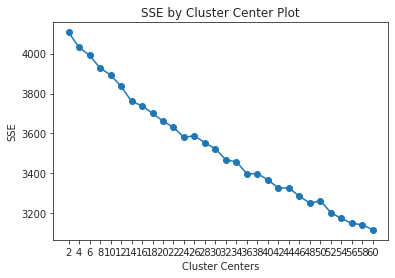

In [ ]:
#Finding Optimal Clusters
#KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise.
# Here I chose 58 clusters.

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
#The SSE is the sum of the squared Euclidean distances of each point to its closest centroid.
    sse = []
    for k in iters:
        #init_size int :Number of samples to randomly sample for speeding up the initialization
        #batch_size int, default=1024. For faster computations,I can set the batch_size greater than 256 * number of cores to enable parallelism on all cores.
        #random_state Determines random number generation for centroid initialization and random reassignment.
        #Inertia: It is the sum of squared distances of samples to their closest cluster center.
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
    plt.figure(figsize=(25, 20))
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')


find_optimal_clusters(X_train_vc, 60)

In [ ]:
#k-means is to try to minimize SSE value
clusters = MiniBatchKMeans(n_clusters=58, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_train_vc)

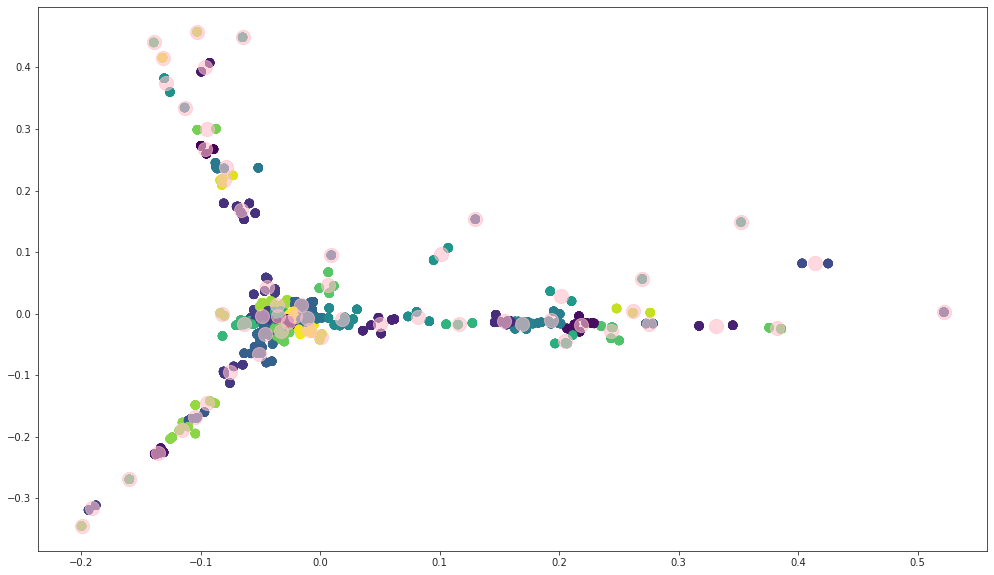

In [ ]:
#Plotting Clusters :
#PCA (Principal Component Analysis)is in conjunction with k-means; is a powerful method for visualizing high dimensional data
    #which is better at capturing global structure of the data :
from sklearn.decomposition import PCA
k_clusters = 58

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=5000, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(17, 10))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=3)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='pink', s=200, alpha=0.6);

In [ ]:
#Train the model to find 58 clusters :

#init = 'k-means++’ : selects initial cluster centroids
#max_iter int, default=100 ;Maximum number of iterations over the complete dataset before stopping independently.
#tolfloat, default=0.0 ; variance-normalized of the mean center squared position changes
model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=5000, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=5000, n_clusters=58, random_state=0, tol=1e-06)

In [ ]:
#Make predictions and display the results :
clusters = model.predict(X_train_vc)

In [ ]:
#Create 2 new columns to display the predicted result :
data["ClusterID"] = clusters
data['category_id'] = data['poste'].factorize()[0]
data.head(12)

title  \
0          ddslweb recrute graphiste freelance france   
1        scarp trading recrute assistante commerciale   
2         fleur de lis recrute des vendeurs vendeuses   
4   masdar consulting recrute ingénieur devops par...   
5                    leadfo recrute assistante canada   
6           marhaba occidental recrute réceptionniste   
8   elite services sécurité recrute des agents de ...   
9                  cabinet gem recrute des comptables   
10         lmobile looking consultant project manager   
12                                 technicien support   
13                    electronic development engineer   
14         az esthétique recrute assistant commercial   

                                    poste  ClusterID  category_id  
0                               Freelance          3            0  
1                         Offres d'emploi         17            1  
2            Vendeur- Ouvrier - Chauffeur          9            2  
4                    Conseil - Consulting         11            3  
5                    Conseil - Consulting         17            3  
6               Restauration - Hôtellerie         40            4  
8                         Offres d'emploi         49            1  
9   Comptabilité – Finance - Statistiques         19            5  
10   Mécanique - Electrique - Energétique         42            6  
12      Informatique - Télécom - Internet         41            7  
13    Ingénierie - Industrie - Production         44            8  
14                  Médical - Paramedical         37            9

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
<ipython-input-313-dd4b639055fd>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 2))
<ipython-input-313-dd4b639055fd>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 2))
<ipython-input-313-dd4b639055fd>:25: RuntimeWar

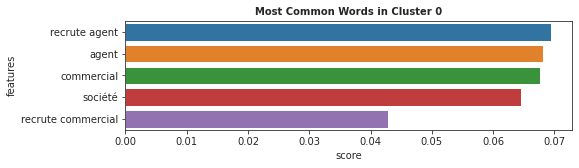

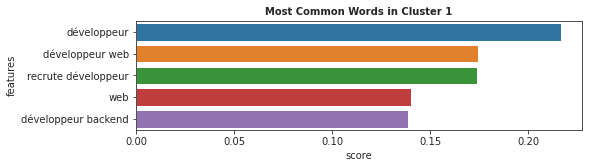

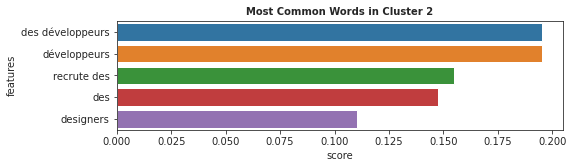

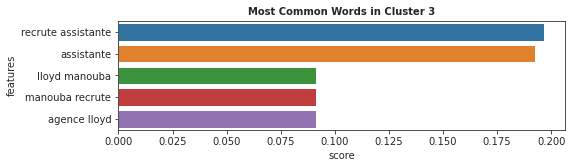

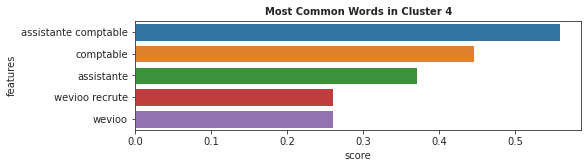

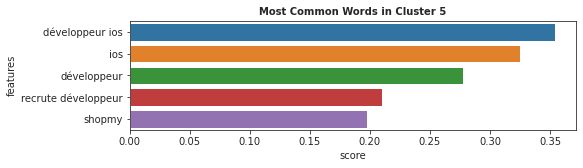

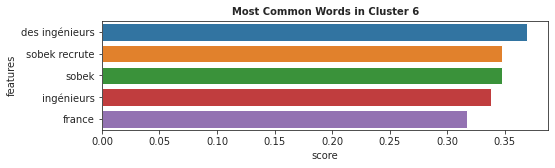

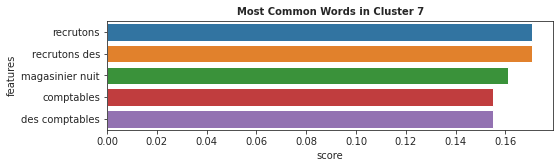

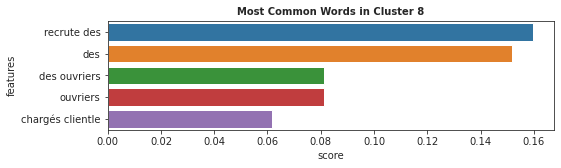

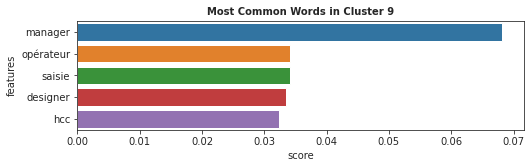

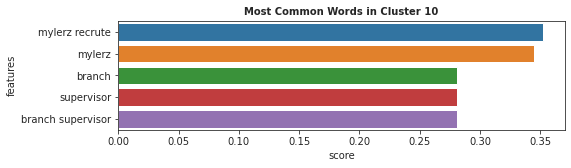

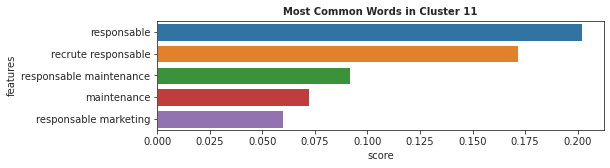

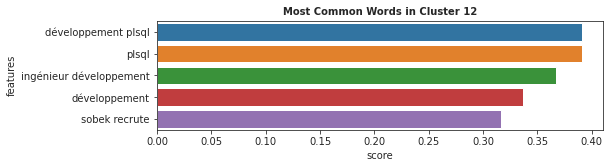

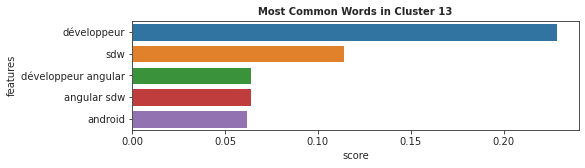

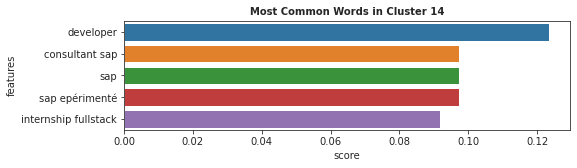

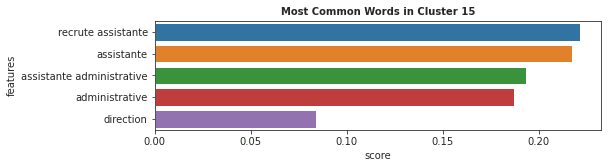

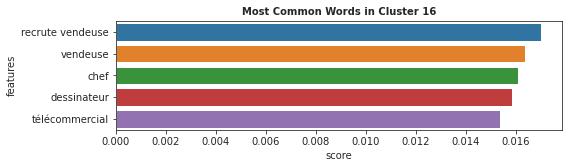

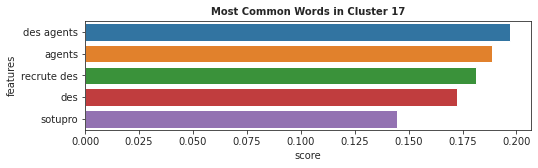

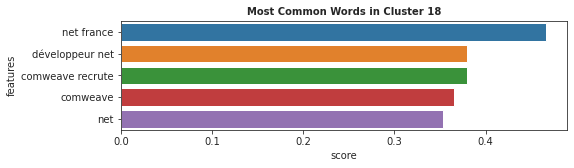

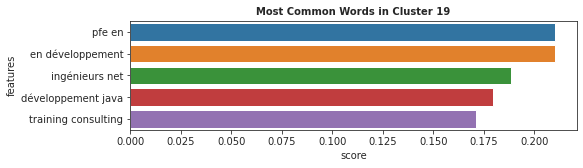

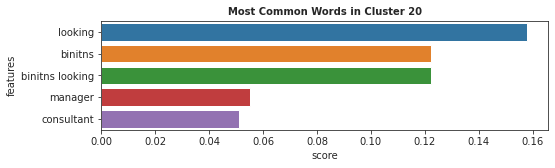

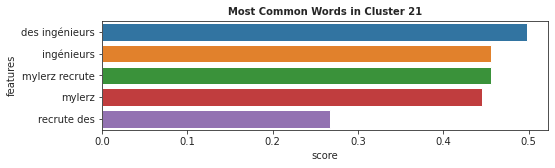

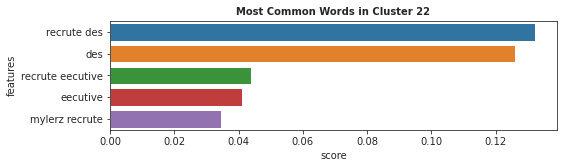

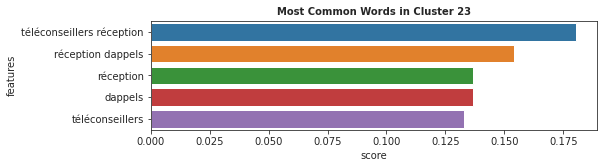

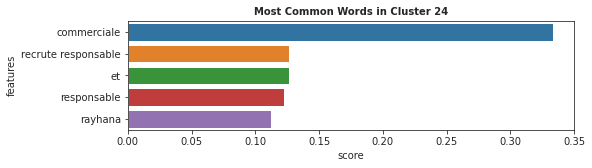

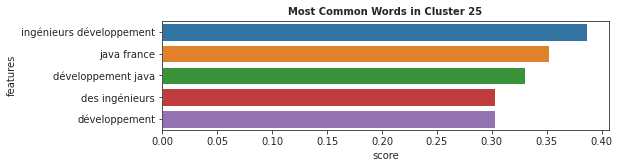

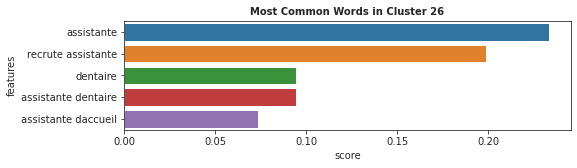

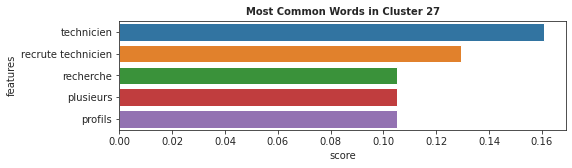

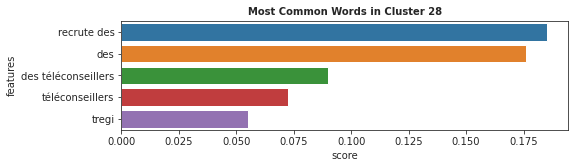

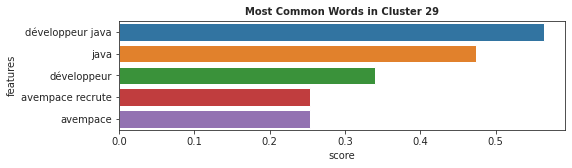

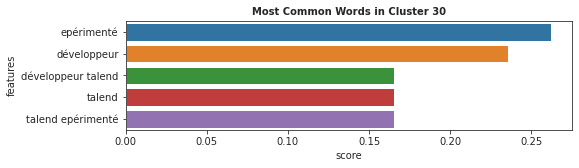

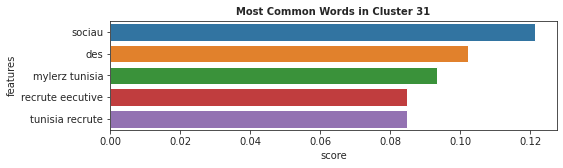

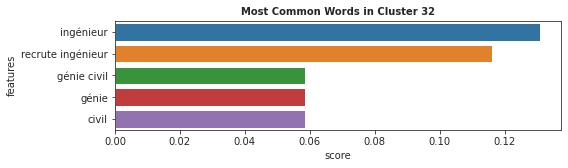

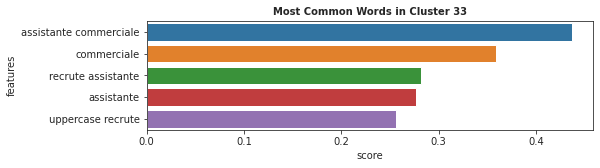

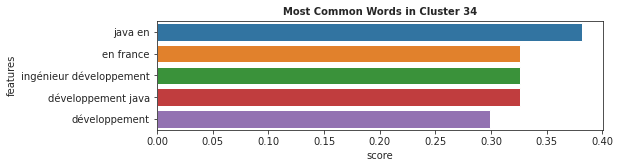

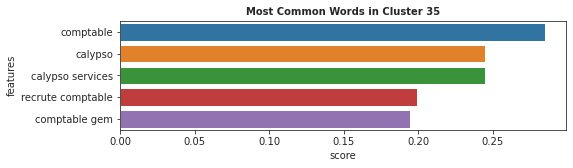

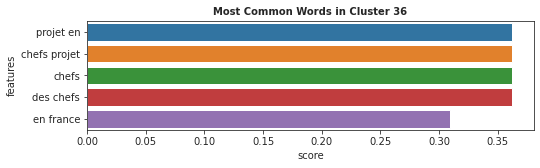

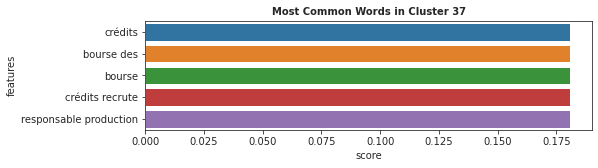

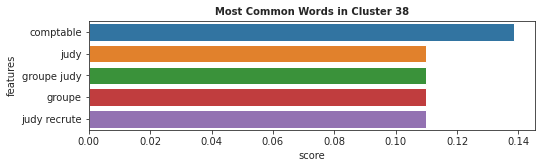

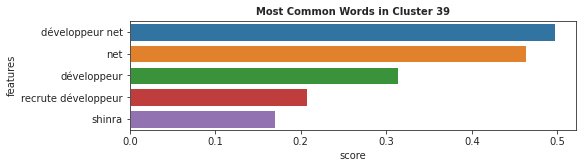

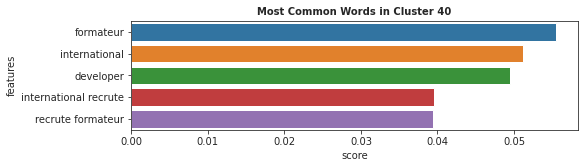

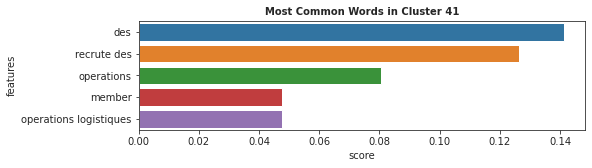

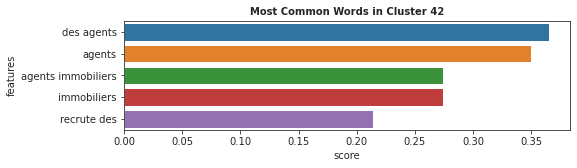

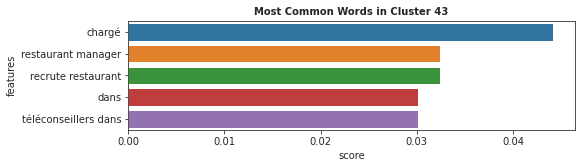

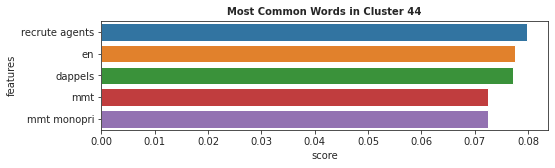

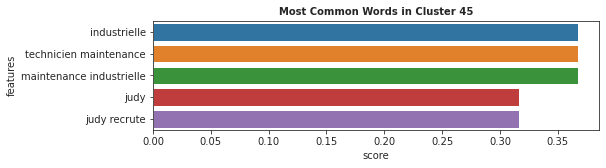

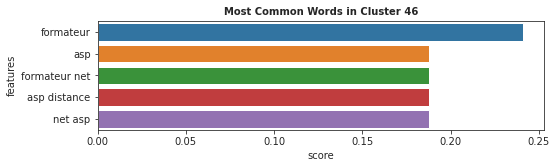

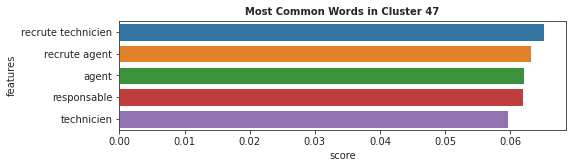

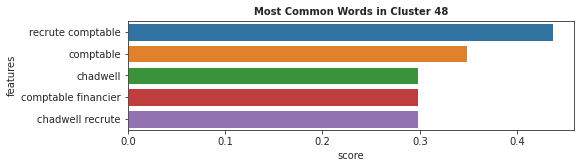

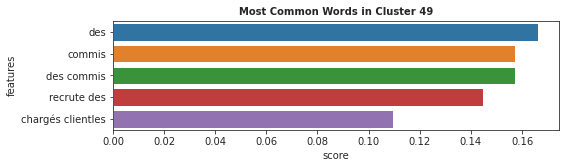

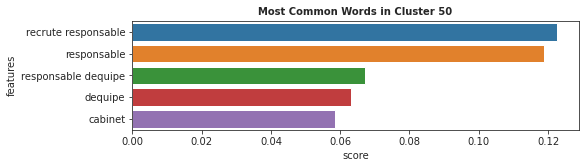

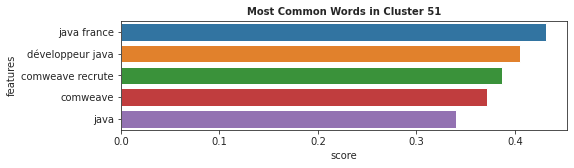

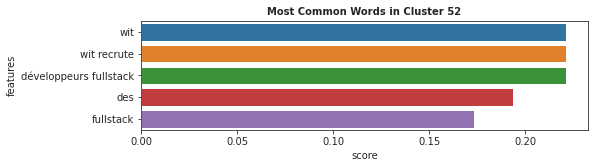

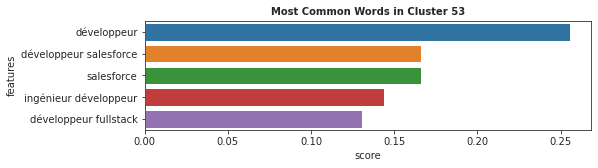

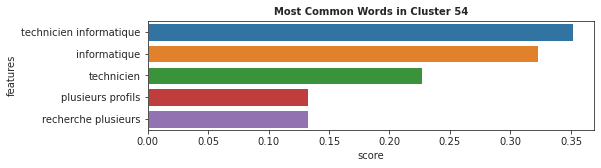

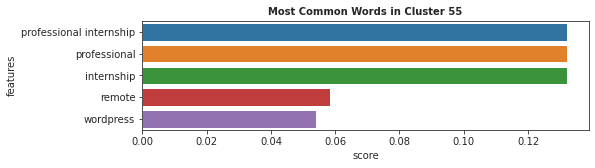

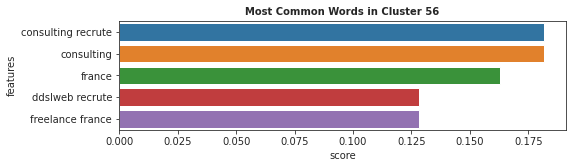

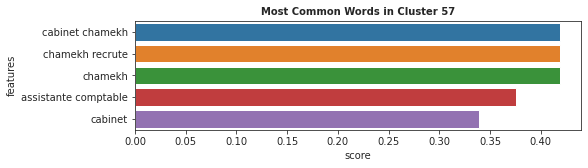

In [ ]:
#View top terms per cluster :

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 5)
plotWords(dfs, 5)

In [ ]:
##View top 8 terms per cluster :
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X_train_vc, clusters, vectorizer.get_feature_names(), 8)


Cluster 0
account,trices,téléopérateurs trices,recrute dessinateur,architecte dessinateur,account developer,architecte,dessinateur

Cluster 1
séquenage,agence,lloyd,assistante commercial,manouba recrute,lloyd manouba,agence lloyd,manouba

Cluster 2
italien,centre dappel,centre dappels,téléconseillers,centre,dans centre,dans,téléconseillers dans

Cluster 3
customer service,distribution,gestionnaire,secrétaire,décorateur,télécommercial,technicien,recrute technicien

Cluster 4
fullstack,développeur fullstack,recrute développeur,sdw,backend,développeur net,net,développeur

Cluster 5
shauber,shauber recrute,délégués médical,des,recrute des,médical,délégués,des délégués

Cluster 6
electronic,administrative et,financire,et,assistante,recrute assistante,assistante administrative,administrative

Cluster 7
sits,engineering,ingénieur,recrute ingénieur,ingénieur génie,civil,génie civil,génie

Cluster 8
kiabi recherche,htel,restaurant,recherche,recherche plusieurs,plusieurs,profils,plusieurs profi

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#View each cluster with their samples:
details = [(name, cluster) for name, cluster in zip(data['title'],kmeans.labels_)]
list1=[]
list2=[]
indexList=[]
for detail in details:
    list1.append(detail[1])  #Add clusters to List1
    list2.append(detail[0])  #Add samples to List2

for i in range(0,58):
    for j in range(len(list1)):
        if (list1[j]==i):
            indexList.append(j)   ##To store the samples corresponding to their clusters temporarily
    print("Cluster °",i," : ")
    for d in indexList:
        print("\t",list2[d])
    indexList=[]

Cluster ° 0  : 
	 concentri tunisie recrute
	 secrétaire daccueil new new
	 gogo travel recrute agent de voyage
	 uptodate language training center recrute professeurfranais
	 un directeur de foire salon et congres
	 société lévolution recrute technicocommercial fer sousse
	 société lévolution recrute magasinierfer
	 société lévolutionrecrute technicocommercial aluminium
	 financier femme
	 intercargo recruteresponsable commercial
	 commercial terrain senior
	 visa voyages recrute agent de billetterie
	 formakt bac recrute commercial
	 plan recrute agent de facturation
	 casaland immobilire la marsa recrute agent immobilier motorisé coordinatrice
	 uptodate language training center recrute professeur allemand
	 société dequipement recrute commercial
	 tunisia vip services recrute agent recouvrement
	 concentri tunisie recrute
	 secrétaire daccueil new new
	 gogo travel recrute agent de voyage
	 uptodate language training center recrute professeurfranais
	 un directeur de foire salon et

# Clustering Data using PySpark:

## I. Creating a spark context.
## II. Reading the Data.
## III. Creating a pipeline.

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession


In [ ]:
#Creating a spark context
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
#Reading the data
raw_df = spark.read.json('jobs.jsonl')

In [ ]:
raw_df.show( )

+--------------------+---------+--------------------+--------------------+--------------------+
|                date| location|               poste|             preview|               title|
+--------------------+---------+--------------------+--------------------+--------------------+
|01 décembre 2022 ...|    Tunis|           Freelance|\n        Dans le...|DDSLweb recrute G...|
|01 décembre 2022 ...|Ben Arous|     Offres d'emploi|\n        Scarp T...|Scarp Trading 24 ...|
|01 décembre 2022 ...|    Tunis|Vendeur- Ouvrier ...|\n        Fleur d...|Fleur de Lis recr...|
|                null|     null|                null|                null|                null|
|01 décembre 2022 ...|    Tunis|Conseil - Consulting|\n        MASDAR ...|Masdar Consulting...|
|01 décembre 2022 ...|    Tunis|Conseil - Consulting|\n        Leadfox...|Leadfox recrute A...|
|01 décembre 2022 ...|   Sousse|Restauration - Hô...|\n        Occiden...|Marhaba Occidenta...|
|                null|     null|        

In [ ]:
##select only the title and poste columns
raw_df=raw_df['title','poste']

In [ ]:
# Drop rows with missing labels :
raw_df = raw_df.dropna()
raw_df.show()

+--------------------+--------------------+
|               title|               poste|
+--------------------+--------------------+
|DDSLweb recrute G...|           Freelance|
|Scarp Trading 24 ...|     Offres d'emploi|
|Fleur de Lis recr...|Vendeur- Ouvrier ...|
|Masdar Consulting...|Conseil - Consulting|
|Leadfox recrute A...|Conseil - Consulting|
|Marhaba Occidenta...|Restauration - Hô...|
|Elite Services Sé...|     Offres d'emploi|
|Cabinet GEM recru...|Comptabilité – Fi...|
|L-Mobile is looki...|Mécanique - Elect...|
|Technicien Suppor...|Informatique - Té...|
|Electronic Develo...|Ingénierie - Indu...|
|Az Esthétique rec...|Médical - Paramed...|
|Télé-Commercial (...|Chargé de clientè...|
|Hôtel The Résiden...|Mécanique - Elect...|
|IStars recrute de...|Informatique - Té...|
|Engineering and C...|Mécanique - Elect...|
| Analyste de données|Comptabilité – Fi...|
|Chargé de recrute...| Ressources Humaines|
|Téléconseillers (...|Téléoperateurs - ...|
|Garanty recrute A...|     Offre

In [ ]:
## Creating a pipeline

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer

#tokenize the document text
tokenizer = Tokenizer(inputCol="title", outputCol="tokens")
tokenized = tokenizer.transform(raw_df).cache()
##Remove specific stopwords
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="tokens",
outputCol="stopWordsRemovedTokens")
stopWordsRemoved_df = remover.transform(tokenized).cache()
hashingTF = HashingTF (inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=200)
#HashingTF converts documents to vectors of fixed size.
#CountVectorizer converts text documents to vectors which give information of token counts.
#TFIDF to convert documents into vector such that vector reflects the importance of a term to a document in the corpus.
tfVectors = hashingTF.transform(stopWordsRemoved_df).cache()
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
idfModel = idf.fit(tfVectors)
tfIdfVectors = idfModel.transform(tfVectors).cache()

from pyspark.ml.clustering import KMeans

# Trains a KMeans model.
kmeans = KMeans().setK(58).setMaxIter(20)
km_model = kmeans.fit(tfIdfVectors)
clustersTable = km_model.transform(tfIdfVectors)

#Create a pipeline that applies all of the previous processing steps to our data
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])
model = pipeline.fit(raw_df)
results = model.transform(raw_df)
# Make predictions
results.show()

+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|               title|               poste|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|DDSLweb recrute G...|           Freelance|[ddslweb, recrute...|  [ddslweb, recrute...|(200,[77,99,128,1...|(200,[77,99,128,1...|        48|
|Scarp Trading 24 ...|     Offres d'emploi|[scarp, trading, ...|  [scarp, trading, ...|(200,[85,87,90,16...|(200,[85,87,90,16...|        33|
|Fleur de Lis recr...|Vendeur- Ouvrier ...|[fleur, de, lis, ...|  [fleur, de, lis, ...|(200,[1,32,82,117...|(200,[1,32,82,117...|        35|
|Masdar Consulting...|Conseil - Consulting|[masdar, consulti...|  [masdar, consulti...|(200,[41,85,99,10...|(200,[41,85,99,10...|         5|
|Leadfox recr

In [ ]:
#View only the title and cluster columns :(to check)
results=results['title','prediction']
results.show()

+--------------------+----------+
|               title|prediction|
+--------------------+----------+
|DDSLweb recrute G...|        48|
|Scarp Trading 24 ...|        33|
|Fleur de Lis recr...|        35|
|Masdar Consulting...|         5|
|Leadfox recrute A...|        37|
|Marhaba Occidenta...|        37|
|Elite Services Sé...|        54|
|Cabinet GEM recru...|        25|
|L-Mobile is looki...|        33|
|Technicien Suppor...|        37|
|Electronic Develo...|        28|
|Az Esthétique rec...|        46|
|Télé-Commercial (...|        37|
|Hôtel The Résiden...|        47|
|IStars recrute de...|        37|
|Engineering and C...|        37|
| Analyste de données|        37|
|Chargé de recrute...|        37|
|Téléconseillers (...|        33|
|Garanty recrute A...|        37|
+--------------------+----------+
only showing top 20 rows



In [ ]:
#View the clustered data:
result = results.select("title", "prediction") \
    .collect()

for row in result:
    print("title : %s , belongs to cluster  %s"
          % (row.title, row.prediction))

title : DDSLweb recrute Graphiste Freelance – France , belongs to cluster  48
title : Scarp Trading 24 recrute Assistante Commerciale , belongs to cluster  33
title : Fleur de Lis recrute des Vendeurs / Vendeuses , belongs to cluster  35
title : Masdar Consulting recrute Ingénieur DevOps –  Paris, France , belongs to cluster  5
title : Leadfox recrute Assistante – Canada , belongs to cluster  37
title : Marhaba Occidental recrute Réceptionniste , belongs to cluster  37
title : Elite Services Sécurité recrute des Agents de Sécurité , belongs to cluster  54
title : Cabinet GEM recrute des Comptables , belongs to cluster  25
title : L-Mobile is looking for Consultant / Project Manager , belongs to cluster  33
title : Technicien Support IT H/F , belongs to cluster  37
title : Electronic Development Engineer , belongs to cluster  28
title : Az Esthétique recrute Assistant Commercial , belongs to cluster  46
title : Télé-Commercial ( H/F) , belongs to cluster  37
title : Hôtel The Résidence 

In [ ]:
#View the clustered data:(Title % prediciton)
col_names = ['title', 'prediction']
results.select(*col_names).show()

+--------------------+----------+
|               title|prediction|
+--------------------+----------+
|DDSLweb recrute G...|        48|
|Scarp Trading 24 ...|        33|
|Fleur de Lis recr...|        35|
|Masdar Consulting...|         5|
|Leadfox recrute A...|        37|
|Marhaba Occidenta...|        37|
|Elite Services Sé...|        54|
|Cabinet GEM recru...|        25|
|L-Mobile is looki...|        33|
|Technicien Suppor...|        37|
|Electronic Develo...|        28|
|Az Esthétique rec...|        46|
|Télé-Commercial (...|        37|
|Hôtel The Résiden...|        47|
|IStars recrute de...|        37|
|Engineering and C...|        37|
| Analyste de données|        37|
|Chargé de recrute...|        37|
|Téléconseillers (...|        33|
|Garanty recrute A...|        37|
+--------------------+----------+
only showing top 20 rows



In [ ]:
#sort the clustered data :
from pyspark.sql.functions import *
results.sort("prediction","title").show(n=3000,truncate=False)
results.sort(col("prediction"),col("title")).show(n=3000,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|Téléconseillers dans un centre d’appels                                                                                               |0         |
|Téléconseillers dans un centre d’appels                                                                                               |0         |
|Téléconseillers dans un centre d’appels [Italien, Espagnol,Allemand requis]                                                           |0         |
|Téléconseillers dans un centre d’appels [Italien, Espagnol,Allemand requis]                                    

In [ ]:
#Sort by Ascending (ASC)
results.sort(results.prediction.asc(),results.title.asc()).show(n=3000,truncate=False)
results.sort(col("prediction").asc(),col("title").asc()).show(n=3000,truncate=False)
results.orderBy(col("prediction").asc(),col("title").asc()).show(n=3000,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|title                                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|Téléconseillers dans un centre d’appels                                                                                               |0         |
|Téléconseillers dans un centre d’appels                                                                                               |0         |
|Téléconseillers dans un centre d’appels [Italien, Espagnol,Allemand requis]                                                           |0         |
|Téléconseillers dans un centre d’appels [Italien, Espagnol,Allemand requis]                                    

In [ ]:
from pyspark.sql.functions import *
#group by cluster and get all samples into a list:
new_df=results.groupBy(col("prediction")).agg(collect_list(col("title")).alias("title"))

In [ ]:
#Sort by Ascending to get a better view :
new_df.sort(new_df.prediction.asc(),new_df.title.asc()).show(n=3000,truncate=False)
new_df.sort(col("prediction").asc(),col("title").asc()).show(n=3000,truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<center><h1 style="font-family: 'Times New Roman'; letter-spacing: 0.03em;">Thank you so much for reading notebook, i appreciate it. Preparing this notebook took me a great deal of time.  </h1></center>